In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, \
                              get_system_from_template, \
                              get_arch_from_template, \
                              get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
from sklearn import linear_model
from dsn.util.plot_util import PCA

import os
os.chdir('../../')

In [32]:
variance = 0.1
c_init_ords = np.array([0])
start_rs = 1
num_rs = 5
random_seeds = np.arange(start_rs, start_rs+num_rs)

repeats_list = [2]
sigma_inits = [2.0]

nlayers = 2
upl = 10

sysname = 'LowRankRNN'
dirstr = 'LowRankRNN'
rank = 1
input_type = 'input'
behavior_type = 'BI'
param_dict = {'rank':rank,
              'input_type':input_type,
              'behavior_type':behavior_type,
              'solve_its':50,
              'variance':variance,
              'gauss_newton':False,
              'solve_eps':0.2}
system = get_system_from_template(sysname, param_dict)

alpha=0.05
frac_samps=0.2
tol = []
tol_inds = []

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
    'tol_inds':[],
}

best_models = []
ME_its = []
ME_vals = []

for repeats in repeats_list:
    for sigma_init in sigma_inits:
        arch_params = {
                       'D':system.D,
                       'sigma_init':sigma_init,
                       'repeats':repeats,
                       'nlayers':nlayers,
                       'upl':upl,
                      }

        param_dict.update(arch_params)
        arch_dict = get_arch_from_template(system, param_dict)

        best_model, max_ME, ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, 
                                                           random_seeds, dirstr, conv_dict)
        best_models.append(best_model)
        ME_its.append(ME_it)
        ME_vals.append(max_ME)

In [33]:
max_ME_arch_ind = np.argmax(np.array(ME_vals))
ME_model = best_models[max_ME_arch_ind]
ME_it = ME_its[max_ME_arch_ind]
ME_val = ME_vals[max_ME_arch_ind]

0
dist (300, 3)


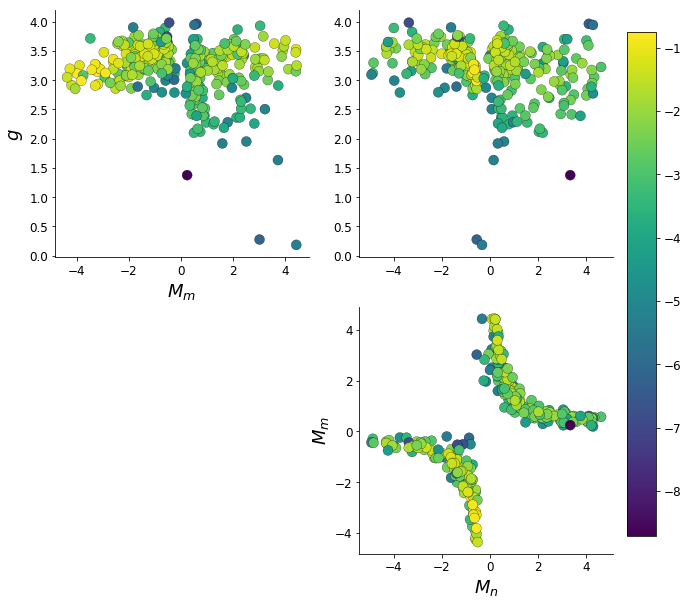

In [45]:
Zs, log_q_zs, axs = dsn_pairplots([ME_model], 'Zs', system, AL_final_its=[ME_it], fontsize=18,
                                  c_str='log_q_z', outlier_stds=8)

0
dist (300, 4)


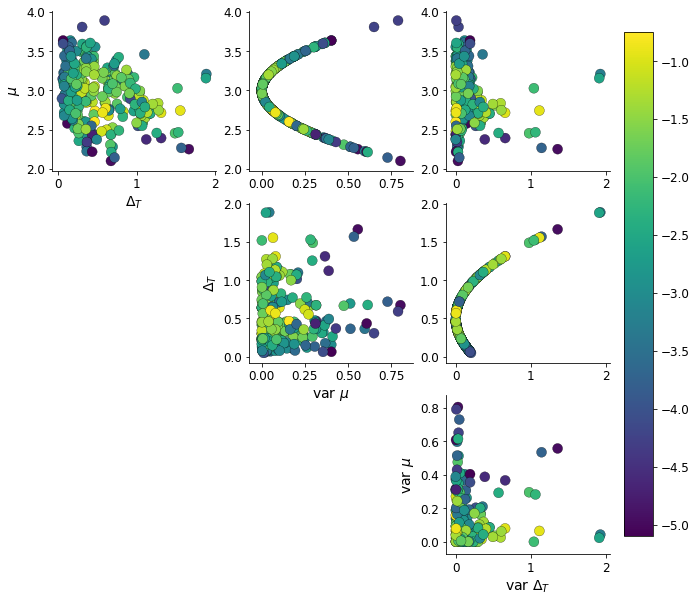

In [46]:

T_xs, _, axs = dsn_pairplots([ME_model], 'T_xs', system, [ME_it])


In [102]:
Z = Zs[0]
print(Z.shape)
mus = T_xs[0][:,0]
delta_Ts = T_xs[0][:,1]
ind1 = np.argmax(Z[:,1]*Z[:,2] - np.abs(Z[:,1]-Z[:,2] + delta_Ts))
ind2 = np.argmax(-Z[:,1]*Z[:,2] - np.abs(Z[:,1]-Z[:,2]))
"""ind1 = np.argmax(mus + delta_Ts)
print(mus[ind1], delta_Ts[ind1])
ind2 = np.argmax(mus - delta_Ts)
print(mus[ind2], delta_Ts[ind2])
ind3 = np.argmax(-mus + delta_Ts)
print(mus[ind3], delta_Ts[ind3])
ind4 = np.argmax(-mus - delta_Ts)
print(mus[ind4], delta_Ts[ind4])
"""
inds = [ind1, ind2]

(300, 3)


0
dist (300, 3)
[-1.82713874 -0.50959529] [3.9013873  3.08531141]
[-1.61611654 -0.80725311] [3.9013873  3.08531141]
[-1.61611654 -0.80725311] [-1.82713874 -0.50959529]


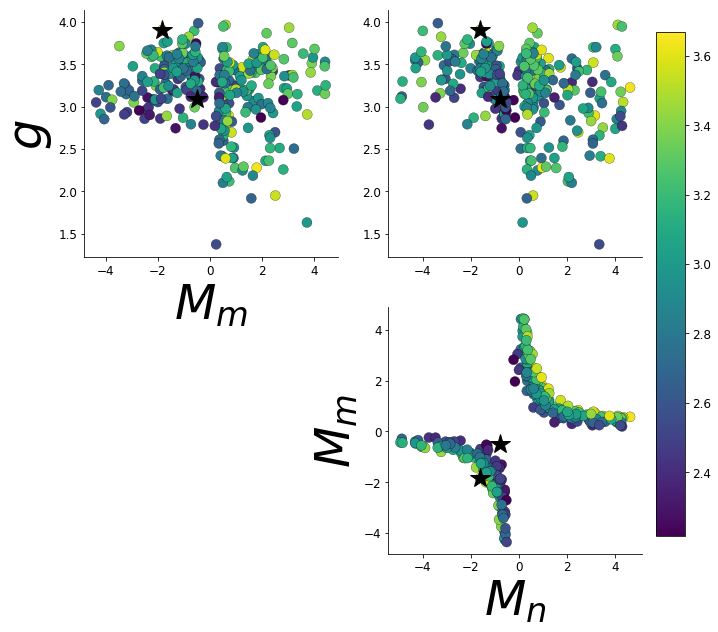

In [127]:
fontsize = 48
_, _, axs = dsn_pairplots([ME_model], 'Zs', system, AL_final_its=[ME_it], fontsize=fontsize,
                                  c_str='T_x1', outlier_stds=2)
for i in range(system.D-1):
    for j in range(i+1, system.D):
        print(Z[inds,j], Z[inds,i])
        ax = axs[i,j-1]
        ax.plot(Z[inds,j], Z[inds,i], 'k*', markersize=20)
plt.savefig('../written/NN2019/figs/fig5/DSN_mu.pdf')
plt.show()

0
dist (300, 3)
[-1.82713874 -0.50959529] [3.9013873  3.08531141]
[-1.61611654 -0.80725311] [3.9013873  3.08531141]
[-1.61611654 -0.80725311] [-1.82713874 -0.50959529]


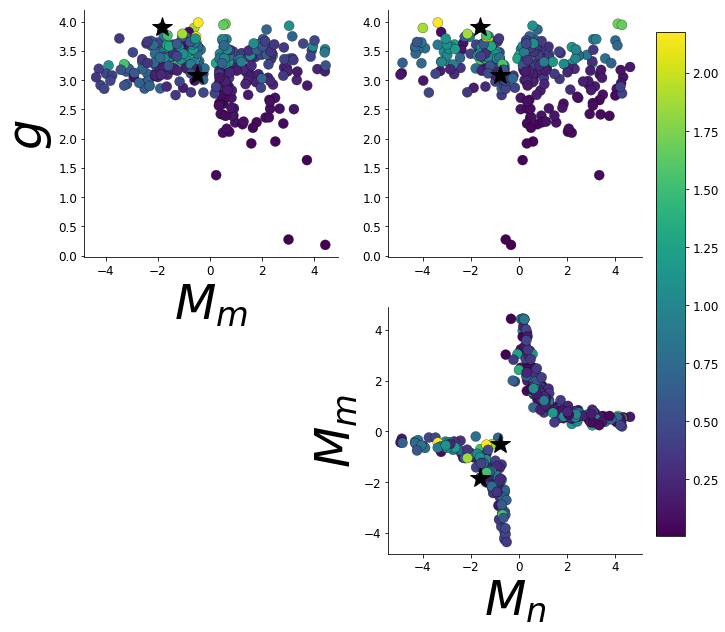

In [128]:
Zs, log_q_zs, axs = dsn_pairplots([ME_model], 'Zs', system, AL_final_its=[ME_it], fontsize=fontsize,
                                  c_str='T_x2', outlier_stds=4)
for i in range(system.D-1):
    for j in range(i+1, system.D):
        print(Z[inds,j], Z[inds,i])
        ax = axs[i,j-1]
        ax.plot(Z[inds,j], Z[inds,i], 'k*', markersize=20)
plt.savefig('../written/NN2019/figs/fig5/DSN_delta_T.pdf')
plt.show()

0
dist (300, 4)
[-1.82713874 -0.50959529] [3.9013873  3.08531141]
[-1.61611654 -0.80725311] [3.9013873  3.08531141]
[-1.61611654 -0.80725311] [-1.82713874 -0.50959529]


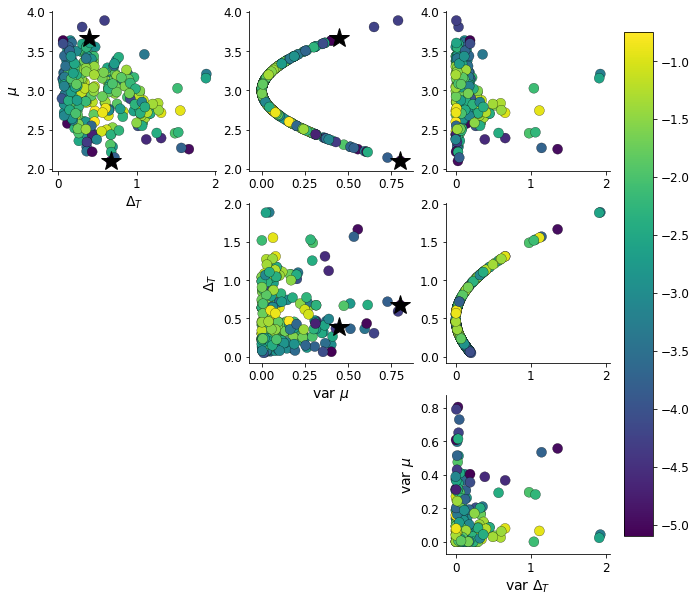

In [105]:
T_xs, _, axs = dsn_pairplots([ME_model], 'T_xs', system, [ME_it])
for i in range(system.D-1):
    for j in range(i+1, system.D):
        print(Z[inds,j], Z[inds,i])
        ax = axs[i,j-1]
        ax.plot(T_xs[0][inds,j], T_xs[0][inds,i], 'k*', markersize=20)
plt.show()

In [107]:
from dsn.util.np_lrrnn import sample_LRRNN, sim_RNN, measure_mu, measure_kappa, measure_vars

Z = Zs[0]
M = Z.shape[0]
M = 10
N = 2000
n_samps = 10
t_start = 500
T = 1500

mus = np.zeros((M, n_samps))
kappas = np.zeros((M, n_samps))
delta_infs = np.zeros((M, n_samps))
delta_Ts = np.zeros((M, n_samps))

xs = []
np.random.seed(0)
mus = []
for i in inds:
    print('i', i)
    Z_i = Z[i,:]
    g = Z_i[0]
    Mm = Z_i[1]
    Mn = Z_i[2]
    
    params = {'nettype':'rank1_input', 'g':g, 'Mm':Mm, 'Mn':Mn, 
              'MI':2.0, 'Sm':1.0, 'Sn':1.0, 'SI':0.0,
              'SnI':1.0, 'SmI':0.0, 'Sperp':0.0}
    LRRNN = sample_LRRNN(N, params)
    W = LRRNN['W']
    m = LRRNN['m']
    n = LRRNN['n']
    I = LRRNN['I']
    x0 = m[:,0]

    dt = 0.001
    tau = 0.01
    x = sim_RNN(x0, W, I[:,0], dt, tau, T)
    kappa = measure_kappa(x, n[:,0], t_start)
    mu = measure_mu(kappa, m[:,0], I[:,0], t_start)
    delta_inf, delta_T = measure_vars(x, t_start)
    
    mu_t = np.mean(x, 0)

    xs.append(x)
    mus.append(mu_t)


i 121
i 157


(2000, 1501)


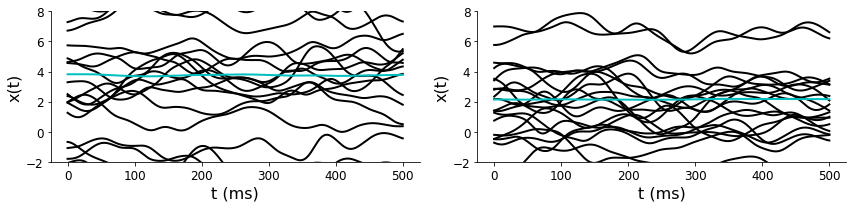

In [129]:
print(x.shape)
fontsize = 16
n_plot = 20
fig, axs = plt.subplots(1,2,figsize=(12,3))
for i in range(2):
    axs[i].plot(xs[i][:n_plot,1000:].T, 'k')
    axs[i].plot(mus[i][1000:].T, 'c')
    axs[i].set_ylim([-2, 8])
    axs[i].set_xlabel('t (ms)', fontsize=fontsize)
    axs[i].set_ylabel('x(t)', fontsize=fontsize)
plt.tight_layout()
plt.savefig('../written/NN2019/figs/fig5/finite_size_ts.pdf')
plt.show()

In [38]:
from dsn.util.dsn_util import load_DSNs
sessions, tf_vars, feed_dicts = load_DSNs([ME_model], [ME_it])

INFO:tensorflow:Restoring parameters from models/LowRankRNN/LowRankRNN_g_Mm_Mn_BI_mu=3.00E+00_5.00E-01_1.00E-01_1.00E-01_flow=2R_2M_2L_10U_M_A_sigma=2.00_c=0_rs=5/model-4
Loaded DGM in 39.07 seconds


a [ 0.163143   -4.79593829 -4.98629342]
b [4.1409516  4.87988535 4.98345594]
-7.948675892830629
-8.075285970204458
-4.7597210369988385


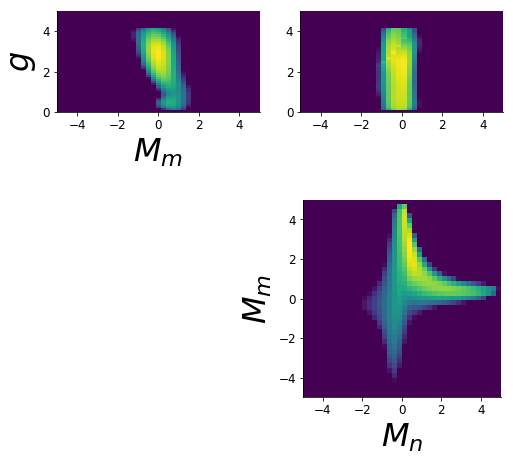

In [39]:
from dsn.util.plot_util import get_log_q_z_mesh, imshow_pairplot

alpha_val = 1.0
buf = 1e-2
K = 40
M = K**system.D
M_samp = 1000
fontsize = 24
ext_fac = 0.0
    
for i in range(1):
    sess = sessions[i]
    tf_var = tf_vars[i]
    feed_dict = feed_dicts[i]
    lb, ub = system.density_network_bounds
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var    
    
    _W = np.random.normal(0.0, 1.0, (1,M_samp,system.D))
    _Z_input_dummy = np.zeros((1,1,system.D))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    _Z_samp = sess.run(Z, feed_dict)
    
    min_samp = np.min(_Z_samp[0], 0)
    max_samp = np.max(_Z_samp[0], 0)
    interval_samp = max_samp - min_samp
    a_grid = np.zeros((system.D))
    b_grid = np.zeros((system.D))
    for j in range(system.D):
        a_grid[j] = max(min_samp[j] - ext_fac*interval_samp[j], lb[j]+buf)
        b_grid[j] = min(max_samp[j] + ext_fac*interval_samp[j], ub[j]-buf)
    print('a', a_grid)
    print('b', b_grid)
    
    Z_grids = np.meshgrid(np.linspace(a_grid[0], b_grid[0], K),
                          np.linspace(a_grid[1], b_grid[1], K),
                          np.linspace(a_grid[2], b_grid[2], K), indexing='ij')
                         
    _Z_grid = np.zeros((1,M,system.D))
    for i in range(system.D):
        _Z_grid[0,:,i] = np.reshape(Z_grids[i], (M,))
        
    log_q_z_mesh = get_log_q_z_mesh(_Z_grid, W, Z_input, Z_INV, log_q_Z, sess, feed_dict, K)
    
    fig, axs = imshow_pairplot(log_q_z_mesh, range(3), system.z_labels,
                               lb=lb, ub=ub, a=a_grid, b=b_grid, fontsize=fontsize+8,
                               figsize=(8,8), cmap=None, alpha=alpha_val, q=80,
                               fig=None, axs=None)
            
            
    plt.savefig('notebooks/images/LRRNN/DSN_BI.png')
    
    plt.show()

In [18]:
check_its = 100
param_dict = {'rank':rank,
              'input_type':input_type,
              'behavior_type':behavior_type,
              'solve_its':check_its,
              'variance':variance,
              'gauss_newton':False,
              'solve_eps':0.2}
system = get_system_from_template(sysname, param_dict)

Z = tf.placeholder(tf.float64, (1,None,system.D))
T_x = system.compute_suff_stats(Z)



data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz
Already warm_started.
data/warm_starts/rank1_BI_a=0.00E+00_-5.00E+00_-5.00E+00_b=5.00E+00_5.00E+00_5.00E+00_step=5.00E-01.npz


In [19]:
xs = system.xs

In [20]:
_Z = Zs[0]
with tf.Session() as sess:
    _xs = sess.run(xs, {Z:np.expand_dims(_Z, 0)})

[[0.13264153 0.13248816 0.13245147 ... 0.15937704 0.15967523 0.15997374]
 [0.16703285 0.16685055 0.16664579 ... 0.14101753 0.14076561 0.14051405]
 [1.62961053 1.63066441 1.63163309 ... 1.70909153 1.70978044 1.7104667 ]
 ...
 [0.71736927 0.71748246 0.71759322 ... 0.71855128 0.71855406 0.71855684]
 [0.95821773 0.95737839 0.95643648 ... 0.84052152 0.83948053 0.8384429 ]
 [0.24484699 0.24473817 0.24457753 ... 0.21851233 0.21825077 0.21798942]]


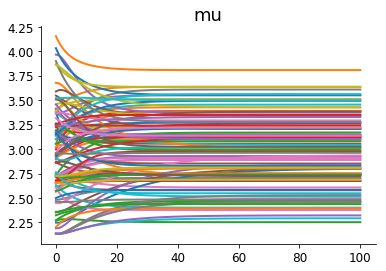

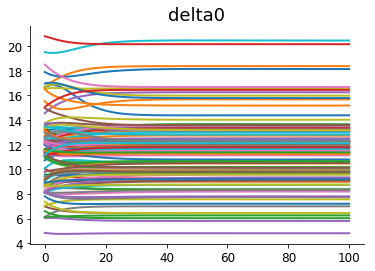

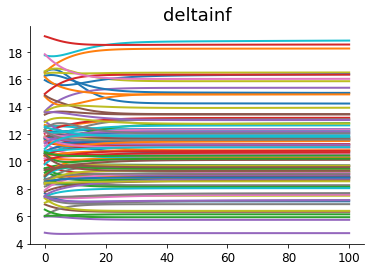

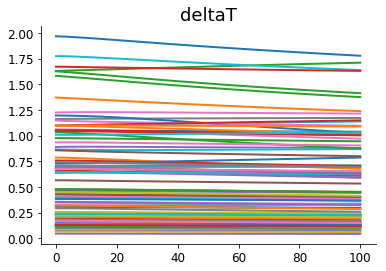

In [21]:
mu = _xs[:,0,:]
square_diff = _xs[:,2,:]
delta_inf = _xs[:,3,:]
delta_0 = np.sqrt(2*square_diff + np.square(delta_inf))
delta_T = delta_0 - delta_inf
print(delta_T)
num_plot = 100 #_xs.shape[0]
plt.figure()
plt.plot(mu[:num_plot,:].T)
plt.title('mu')
plt.show()
plt.figure()
plt.plot(delta_0[:num_plot,:].T)
plt.title('delta0')
plt.show()
plt.figure()
plt.plot(delta_inf[:num_plot,:].T)
plt.title('deltainf')
plt.show()
plt.figure()
plt.plot(delta_T[:num_plot,:].T)
plt.title('deltaT')
plt.show()

In [22]:
from dsn.util.np_lrrnn import sample_LRRNN, sim_RNN, measure_mu, measure_kappa, measure_vars

Z = Zs[0]
M = Z.shape[0]
M = 10
N = 2000
n_samps = 10
t_start = 500
T = 1500

mus = np.zeros((M, n_samps))
kappas = np.zeros((M, n_samps))
delta_infs = np.zeros((M, n_samps))
delta_Ts = np.zeros((M, n_samps))

np.random.seed(0)
for i in range(M):
    print('i', i)
    Z_i = Z[i,:]
    g = Z_i[0]
    Mm = Z_i[1]
    Mn = Z_i[2]
    for j in range(n_samps):
        params = {'nettype':'rank1_input', 'g':g, 'Mm':Mm, 'Mn':Mn, 
                  'MI':2.0, 'Sm':1.0, 'Sn':1.0, 'SI':0.0,
                  'SnI':1.0, 'SmI':0.0, 'Sperp':0.0}
        LRRNN = sample_LRRNN(N, params)
        W = LRRNN['W']
        m = LRRNN['m']
        n = LRRNN['n']
        I = LRRNN['I']
        x0 = m[:,0]

        dt = 0.005
        tau = 0.005
        x = sim_RNN(x0, W, I[:,0], dt, tau, T)
        kappa = measure_kappa(x, n[:,0], t_start)
        mu = measure_mu(kappa, m[:,0], I[:,0], t_start)
        delta_inf, delta_T = measure_vars(x, t_start)
        
        mus[i,j] = mu
        kappas[i,j] = kappa
        delta_infs[i,j] = delta_inf
        delta_Ts[i,j] = delta_T

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9


In [23]:
mu_means = np.mean(mus, axis=1)
mu_vars = np.var(mus, axis=1)
mu_stderr = np.sqrt(mus) / np.sqrt(n_samps)

kappa_means = np.mean(kappas, axis=1)
kappa_vars = np.var(kappas, axis=1)
kappa_stderr = np.sqrt(kappa_vars) / np.sqrt(n_samps)

delta_inf_means = np.mean(delta_infs, axis=1)
delta_inf_vars = np.var(delta_infs, axis=1)
delta_inf_stderr = np.sqrt(delta_inf_vars) / np.sqrt(n_samps)

delta_T_means = np.mean(delta_Ts, axis=1)
delta_T_vars = np.var(delta_Ts, axis=1)
delta_T_stderr = np.sqrt(delta_T_vars) / np.sqrt(n_samps)

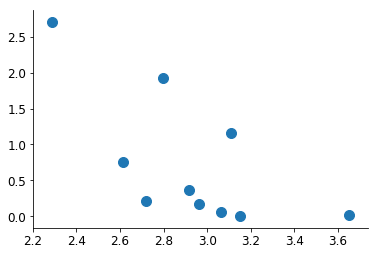

In [24]:
plt.figure()
plt.scatter(mu_means, delta_T_means)
plt.show()

In [25]:
print(T_xs[0].shape)

(300, 4)


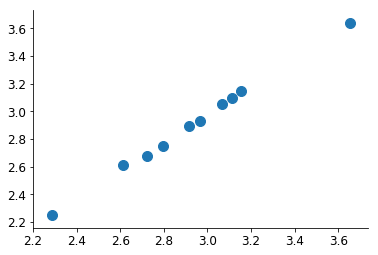

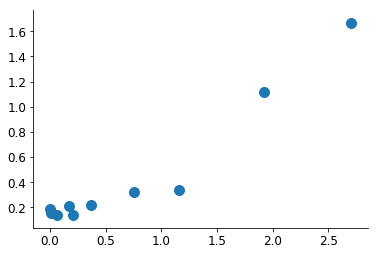

In [26]:
plt.figure()
plt.scatter(mu_means, T_xs[0][:M,0])
plt.show()

plt.figure()
plt.scatter(delta_T_means, T_xs[0][:M,1])
plt.show()